# Pregunta 1

## Funciones de activación

Primero, definimos las funciones de activación que puedan ser requeridas por el algoritmo

##### Softmax

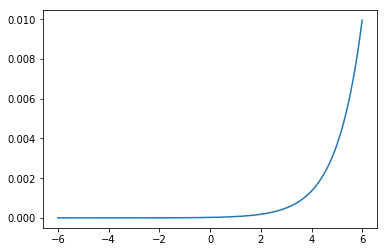

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def softmax(x):
    shiftx = x - np.max(x)
    exps = np.exp(shiftx)
    return exps / np.sum(exps)

testInput = np.arange(-6, 6, 0.01)
plt.plot(testInput, softmax(testInput))
plt.show()

Derivada Softmax

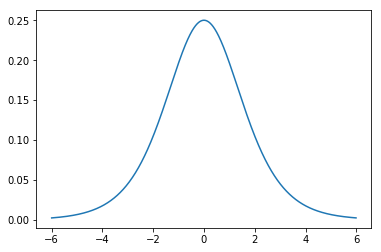

In [2]:
import numpy as np
def softmax_prime(x):
    upper = np.exp(-x)
    down = np.power(1 + np.exp(-x), 2)
    return upper / down

testInput = np.arange(-6, 6, 0.01)
plt.plot(testInput, softmax_prime(testInput))
plt.show()

##### Sigmoid

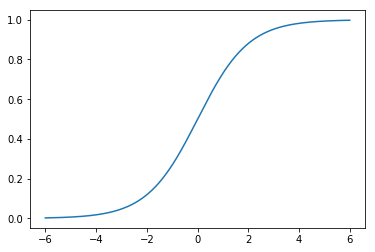

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1/(1+np.exp(-x))

testInput = np.arange(-6, 6, 0.01)
plt.plot(testInput, sigmoid(testInput))
plt.show()

Derivada sigmoid

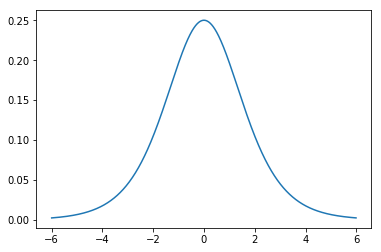

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid_prime(x):
    return np.exp(-x)/((1+np.exp(-x))**2)

testInput = np.arange(-6, 6, 0.01)
plt.plot(testInput, sigmoid_prime(testInput))
plt.show()

##### ReLu

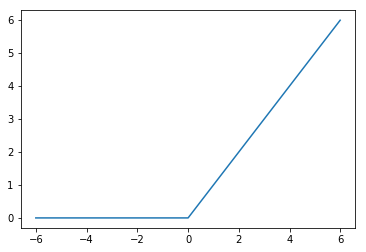

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def relu(x):
    return np.abs(x) * (x > 0)

testInput = np.arange(-6, 6, 0.01)
plt.plot(testInput, relu(testInput))
plt.show()

Derivada ReLU

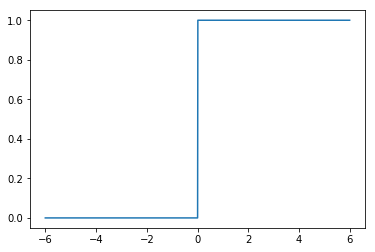

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def relu_prime(x):
    return np.where(x > 0, 1.0, 0.0)

testInput = np.arange(-6, 6, 0.01)
plt.plot(testInput, relu_prime(testInput))
plt.show()

##### Linear

In [7]:
def linear(x):
    return x

## Red neuronal feed-forward

Las ecuaciones requeridas por back propagation corresponden a:

1) $\delta^L = \nabla _a C \odot \sigma ' (z^L)$, con $\nabla_ a C = a^L - y$, donde se puede interpretar a $a^L$ como $\hat{y}$

2) $\delta^l = ((w^{(l + 1)})^T \delta^{(l+1)}) \odot \sigma ' (z^l)$

3) $\frac{\partial C}{\partial b^l_j} = \delta^l_ j$

4) $\frac{\partial C}{\partial w^l_{jk}} = a^{l-1}_k \delta^l_j$

Fuente: http://neuralnetworksanddeeplearning.com/chap2.html

In [8]:
import numpy as np
from random import randint, random, seed, uniform
import keras
    
class Network:
    # The layers variable receives a specification with the following format:
    # [
    #    "neurons": n_neurones,
    #    "activation": "activation_function",
    # ]
    
    activation_function_hash = {
        "softmax": {
            "func": softmax,
            "func_prime": softmax_prime,
        },
        "sigmoid": {
            "func": sigmoid,
            "func_prime": sigmoid_prime,
        },
        
        "relu": {
            "func": relu,
            "func_prime": relu_prime,
        },
        
        "linear": {
            "func": linear,
            "func_prime": 1,
        }
    }
    
    # loss defines the method to calculate cost
    # crossentropy or mse
    def __init__(self, layers, loss="mse"):
        self.layers = layers
        self.loss = loss
        
        # The first layer is the input layer, and does not have biases
        # or weights
        self.biases = np.array([np.random.randn(l["neurons"], 1) for l in layers[1:]])
        
        # The amount of weights depensd on both the amount of neurones on the layer 
        # and the dimension of the inputs.
        self.weights = [np.random.randn(curr_l["neurons"], prev_l["neurons"]) for prev_l, curr_l in zip(layers[:-1], layers[1:])]

    # Returns final output, activation output at each layer
    # and z value at each layer
    def forward_propagation(self, data):
        output = data
        activations = [data.reshape(len(data), 1)]
        zs = []
        
        # We start on the first layer. Note that the input layer
        # is pretty much ignored as it does not have activation
        # functions or anything like that.
        for B, W, layer, index in zip(self.biases, self.weights, self.layers, range(0, len(self.biases))):
            dot = np.dot(W, output)
            dot = dot.reshape(len(dot), 1)
            Z = dot + B

            zs.append(Z)
            activation_string = layer["activation"]
            g = Network.activation_function_hash[activation_string]["func"]
            output = g(Z)
            
            
            
            activations.append(output)

        return activations, zs    
    
    
    # Devuelve el output de la red
    def evaluate(self, X):
        output = []
        for x in X:
            (acts, zs) = self.forward_propagation(x)
            output.append(self.classify(acts[len(self.biases)]))
            
        return np.array(output)
    
    def classify(self, x):
        chosen_class = 2 ** np.argmax(x)
        total_classes = self.layers[-1]["neurons"]
        return (((chosen_class & (1 << np.arange(total_classes)))) > 0).astype(int)
        
        
        
    
    # Receives a single sample X with its 
    # corresponding value Y and returns the 
    # derivatives for the weights and biases
    # We want to get dc/db and dc/dw
    
    def get_total_cost(self):
        if self.loss == "mse":
            return 0.5*np.linalg.norm(a-y)**2
        elif self.loss == "crossentropy":
            return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))
        return None
    def get_delta(self, a, z, y, activation_derivative):
        # Equation 1 says how this should got, at least for mse
        if self.loss == "mse":
            return (a - y) * activation_derivative(z)
        elif self.loss == "crossentropy":
            return (a - y)
        
        return None
    
    def backprop(self, x, y):
        
        
        # Initialize the gradient
        gradient_b = np.array([np.zeros(bias.shape) for bias in self.biases])
        gradient_w = np.array([np.zeros(weight.shape) for weight in self.weights])
        
        # Propagate the input through the network and get all the
        # z outputs and activation outputs of all layers
        # The first activation corresponds to the first input layer
        (acts, zs)  = self.forward_propagation(x)
        
        # Use the specified activation function's derivative
        activation_derivative = Network.activation_function_hash[self.layers[-1]["activation"]]["func_prime"]
        
        # We first calculate the delta value of the output layer, given as
        # delta_cost = aL - y
        # [ , , , , X] (= -1)
        # [ , , , X, ] ( = -2)
        # ....
        # [X, , , , ,] ( = -L)
        
        yHat = np.array(self.classify(acts[-1]))

        delta = self.get_delta(yHat.reshape(3, 1), zs[-1], y.reshape(3, 1), activation_derivative)
        
        # 
        # Gradient B = delta
        gradient_b[-1] = delta
        
        # Gradient W = delta x A(L - 1)T
        gradient_w[-1] = np.dot(delta, acts[-2].T)
        
        # We now have the L layer with its deltas and gradients claculated.
        # Now we iterate over each layer to get the specific deltas
        for l in range(2, len(self.layers)):
            z = zs[-l] # The minus syntax makes the array to get the farther
            
            # Use the specified activation function's derivative
            activation_derivative = Network.activation_function_hash[self.layers[-l]["activation"]]["func_prime"]
            
            delta = np.dot(self.weights[-l + 1].T, delta) * activation_derivative(z)
            
            gradient_b[-l] = delta
            
            gradient_w[-l] = np.dot(delta, acts[-l - 1].T)
            
        return (gradient_b, gradient_w)
            
        
    def SGD(self, trainX, trainY, epochs, learn_rate):
        
        change_b = np.array([np.zeros(b.shape) for b in self.biases])
        change_w = np.array([np.zeros(w.shape) for w in self.weights])
    
        for epoch in range(0, epochs):
            # print("Epoch", epoch + 1)
            for X, Y in zip(trainX, trainY):

                """
                The backprop function will propagate the current information
                through the network and then calculate the gradients of
                each layer. Considering that we have a single bias per layer,
                gradient_b will be an array of size L, being L the total number
                of layers, excluding the input layer.

                gradient_w will be an array of size L too, in which each element
                becomes a vector that represents the gradient of all the weights
                of a layer.
                """
                (gradient_b, gradient_w) = self.backprop(X, Y)

                """
                Now that we have the gradients of the weights, we want to
                store this information for this particular training example in
                order to average it later on. The change_b represents the sum of
                the changes of all training examples for all biases, and change_w
                does the same for all weights.

                Later, as if we were trying to get the average of a list, we will
                divide this sum by the total amount of examples. This will tell
                us the average change of all training examples and allow us to
                modify the weights.
                """
                change_b = [(cb + gb)
                            for cb, gb in zip(change_b, gradient_b)]
                change_w = [(cw + gw)
                            for cw, gw in zip(change_w, gradient_w)]

            self.weights = [weight - (learn_rate / len(trainX)) * weight_change for weight, weight_change in zip(self.weights, change_w)]
            self.biases = [bias -(learn_rate / len(trainX))*bias_change for bias, bias_change in zip(self.biases, change_b)]    
        
                
    
# The network should have 2 layers, the first with 32 neurons and the second with 16
# You basically will have an architecture like this:
# input -> layer 1 (32) -> later 2 (16) -> output (3 neurons with softmax activation function)

"""
Bellow here we test our implementation
"""
import keras
seed(10)
T = 100
M = 5
dataX = np.array([np.random.randn(M, 1) for n in range(0, T)])
dataY = [randint(0,2) for n in range(0, T)]
dataYOnehot = keras.utils.to_categorical(dataY)
network = Network([{
    "neurons": M,
    "activation": "linear"
}, {
    "neurons": 32,
    "activation": "sigmoid"
}, {
    "neurons": 16,
    "activation": "sigmoid"
}, {
    "neurons": 3,
    "activation": "softmax"
}])

x = dataX[0]
y = dataY[0]


network.SGD(dataX, dataYOnehot, 300, 0.1)
yHat = np.array(network.evaluate(dataX))

# Measure accuracy

from sklearn.metrics import accuracy_score
print("Tests passed with a score of: ", accuracy_score(dataYOnehot, yHat))








Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Tests passed with a score of:  0.36


## Función de evaluación y categorización

La función que permite evaluar un vector de datos particulares está implementada en la clase de la red neuronal previamente utilizada, bajo el nombre `evaluate`. De forma análoga, la función para clasificar está también dentro de la red bajo el nombre de `classify`

## Validación del algoritmo

En esta sección, se genera el dataset iris y se definen funciones que permitirán evaluar fácilmente la red neuronal.

##### Generación del dataset

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
X_train,y_train = load_iris(return_X_y=True)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# Convert the targets to one hot vectors
import keras
y_onehot = keras.utils.to_categorical(y_train)

##### Entrenamiento, clasificación y error

Definimos una función que nos permitirá probar nuestra red neuronal en pocas lineas de código, ajustando distintos parámetros.

In [17]:
from sklearn.metrics import accuracy_score
# Funcion que recibe parametros de la red y que retorna el error de entrenamiento
# X:               Vector de datos de prueba
# y:               Output de datos de prueba numérico
# activations:     Lista con las activaciones requeridas. Debe ser un total de
#                  4 y se permite: linear, sigmoid, softmax, relu.
# epochs:          Número de iteraciones
# learning_rate:   Learning rate
def evaluate_network_with_parameters(X, y, activations, epochs, learning_rate, loss="mse"):
    # Entrenamos primero nuestra red neuronal
    M = len(X[0])
    
    network = Network([{
        "neurons": M,
        "activation": "linear",
    }, {
        "neurons": 32,
        "activation": activations[0]
    }, {
        "neurons": 16,
        "activation": activations[1]
    }, {
        "neurons": 3,
        "activation": activations[2]
    }], loss=loss)
    network.SGD(X, y, epochs, learning_rate)

    # El resultado es el siguiente
    result = network.evaluate(X)
    
    return accuracy_score(y_onehot, result)


##### Experimentos

A continuación se realizan pruebas con distintas funciones de activación en la capa intermedia

In [18]:
import numpy as np
from timeit import default_timer as timer
# Definición del número de epochs a probar
epochs = np.arange(10, 1000, 50)

X = X_train
y = y_onehot

results = {
    "mse": {
        "sigmoid_sigmoid": {},
        "relu_relu": {},
        "sigmoid_relu": {},
        "relu_sigmoid": {},
    },
    "crossentropy" : {
        "sigmoid_sigmoid": {},
        "relu_relu": {},
        "sigmoid_relu": {},
        "relu_sigmoid": {},
    }
}

for loss in results:
    for activation_string in results[loss]:
        layers = activation_string.split("_")
        layers.append("softmax")
        
        results[loss][activation_string]["results"] = []
        results[loss][activation_string]["exec_time"] = []
        
        print("Evaluating", loss, layers[0], layers[1])
        for n in epochs:
            start = timer()
            accuracy = evaluate_network_with_parameters(X, y, layers, n, 0.1, loss="mse")
            end = timer()
            results[loss][activation_string]["results"].append(accuracy)
            results[loss][activation_string]["exec_time"].append(end - start)


Evaluating mse sigmoid sigmoid


/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in square
  """
/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Evaluating mse relu relu


/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


Evaluating mse sigmoid relu
Evaluating mse relu sigmoid
Evaluating crossentropy sigmoid sigmoid
Evaluating crossentropy relu relu
Evaluating crossentropy sigmoid relu
Evaluating crossentropy relu sigmoid


##### Resultados

A continuación se grafican los resultados para los experimentos:

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:1506: UserWarning: No labeled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labeled objects found. "


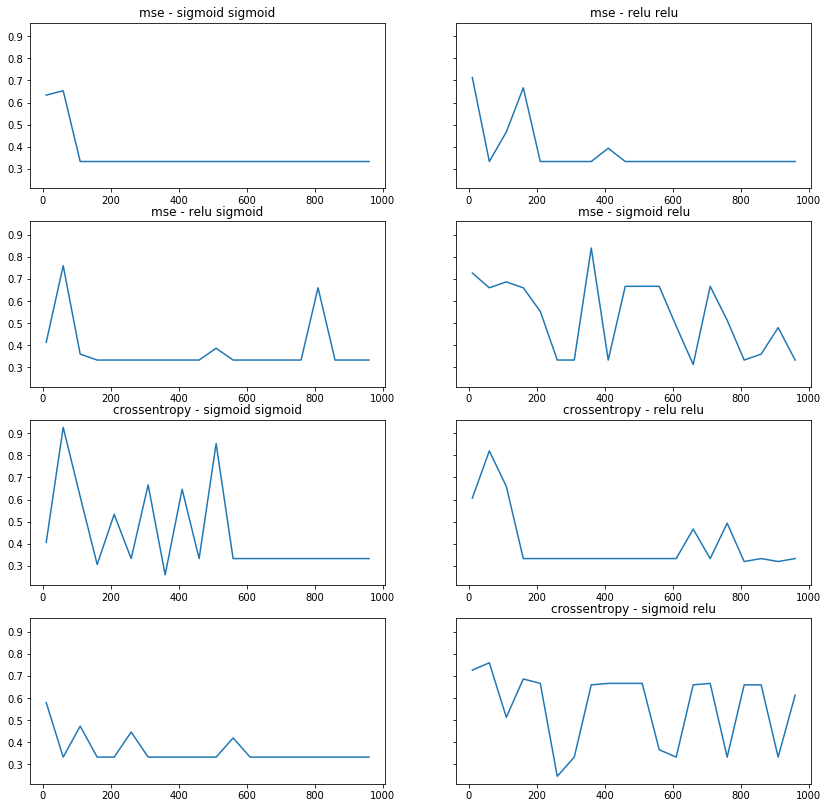

'\nplt.figure(figsize=(10, 8))\nplt.plot(epochs, results["mse"]["sigmoid_sigmoid"]["results"], label="Accuracy")\nplt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)\nplt.xlabel(\'Cantidad de epochs\')\nplt.ylabel(\'Accuracy\')\n'

In [40]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 14), sharey=True)
fig.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

axes[0, 0].plot(epochs, results["mse"]["sigmoid_sigmoid"]["results"], label="Accuracy")
axes[0, 0].set_title("mse - sigmoid sigmoid")

axes[0, 1].plot(epochs, results["mse"]["relu_relu"]["results"], label="Accuracy")
axes[0, 1].set_title("mse - relu relu")

axes[1, 0].plot(epochs, results["mse"]["relu_sigmoid"]["results"], label="Accuracy")
axes[1, 0].set_title("mse - relu sigmoid")

axes[1, 1].plot(epochs, results["mse"]["sigmoid_relu"]["results"], label="Accuracy")
axes[1, 1].set_title("mse - sigmoid relu")

axes[2, 0].plot(epochs, results["crossentropy"]["sigmoid_sigmoid"]["results"], label="Accuracy")
axes[2, 0].set_title("crossentropy - sigmoid sigmoid")

axes[2, 1].plot(epochs, results["crossentropy"]["relu_relu"]["results"], label="Accuracy")
axes[2, 1].set_title("crossentropy - relu relu")


axes[3, 0].plot(epochs, results["crossentropy"]["relu_sigmoid"]["results"], label="Accuracy")
axes[3, 1].set_title("crossentropy - relu sigmoid")

axes[3, 1].plot(epochs, results["crossentropy"]["sigmoid_relu"]["results"], label="Accuracy")
axes[3, 1].set_title("crossentropy - sigmoid relu")


plt.show()
"""
plt.figure(figsize=(10, 8))
plt.plot(epochs, results["mse"]["sigmoid_sigmoid"]["results"], label="Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Cantidad de epochs')
plt.ylabel('Accuracy')
"""
